In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Data loading

In [92]:
# Load and prepare the data
df = pd.read_csv(r"Data\Clean Data\DATACLEAN.csv", index_col=0)
df.index = pd.to_datetime(df.index)

# Resample to quarterly data
df_quarterly = df.resample('Q').last()

# Create target variables for different quarterly horizons
for horizon in [1, 2, 4]:
    df_quarterly[f'Federal_Funds_Rate_t+{horizon}'] = df_quarterly['Federal_Funds_Rate'].shift(-horizon)

# Print initial data info
print("Initial date range:", df_quarterly.index.min(), "to", df_quarterly.index.max())

Initial date range: 1913-03-31 00:00:00 to 2024-12-31 00:00:00


C:\Users\westm\AppData\Local\Temp\ipykernel_52028\3462250333.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quarterly = df.resample('Q').last()


# Target variables

In [93]:
# Modify the feature selection to include Federal Funds Rate
feature_cols = [col for col in df_quarterly.columns 
                if not col.startswith('Federal_Funds_Rate_t+')] # Removed the exclusion of 'Federal_Funds_Rate'
X = df_quarterly[feature_cols].copy()

In [94]:
# Print info about missing values before handling them
print("\nMissing values per column:")
print(X.isna().sum())
print("\nTotal rows in dataset:", len(X))

# Handle missing values
X = X.fillna(method='ffill')
X = X.fillna(method='bfill')

# Print feature list
print("\nFeatures used in model:")
print(feature_cols)


Missing values per column:
GDP                              136
Industrial_Production             24
Retail_Sales                     316
Wage_and_Salary                  188
Consumer_Price_Index             136
Money_Supply_M2                  184
Personal_Consumption             184
Producer_Price_Index               0
Average_Hourly_Earnings          372
Job_Openings                     351
Unemployment_Rate                140
Commercial_Real_Estate_Prices    368
Median_House_Price               200
Treasury_Spread_10Y_2Y           253
Nasdaq_Composite                 232
Federal_Funds_Rate               166
dtype: int64

Total rows in dataset: 448

Features used in model:
['GDP', 'Industrial_Production', 'Retail_Sales', 'Wage_and_Salary', 'Consumer_Price_Index', 'Money_Supply_M2', 'Personal_Consumption', 'Producer_Price_Index', 'Average_Hourly_Earnings', 'Job_Openings', 'Unemployment_Rate', 'Commercial_Real_Estate_Prices', 'Median_House_Price', 'Treasury_Spread_10Y_2Y', 'Nasdaq_Co

C:\Users\westm\AppData\Local\Temp\ipykernel_52028\3193787551.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')
C:\Users\westm\AppData\Local\Temp\ipykernel_52028\3193787551.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='bfill')


# Description of set

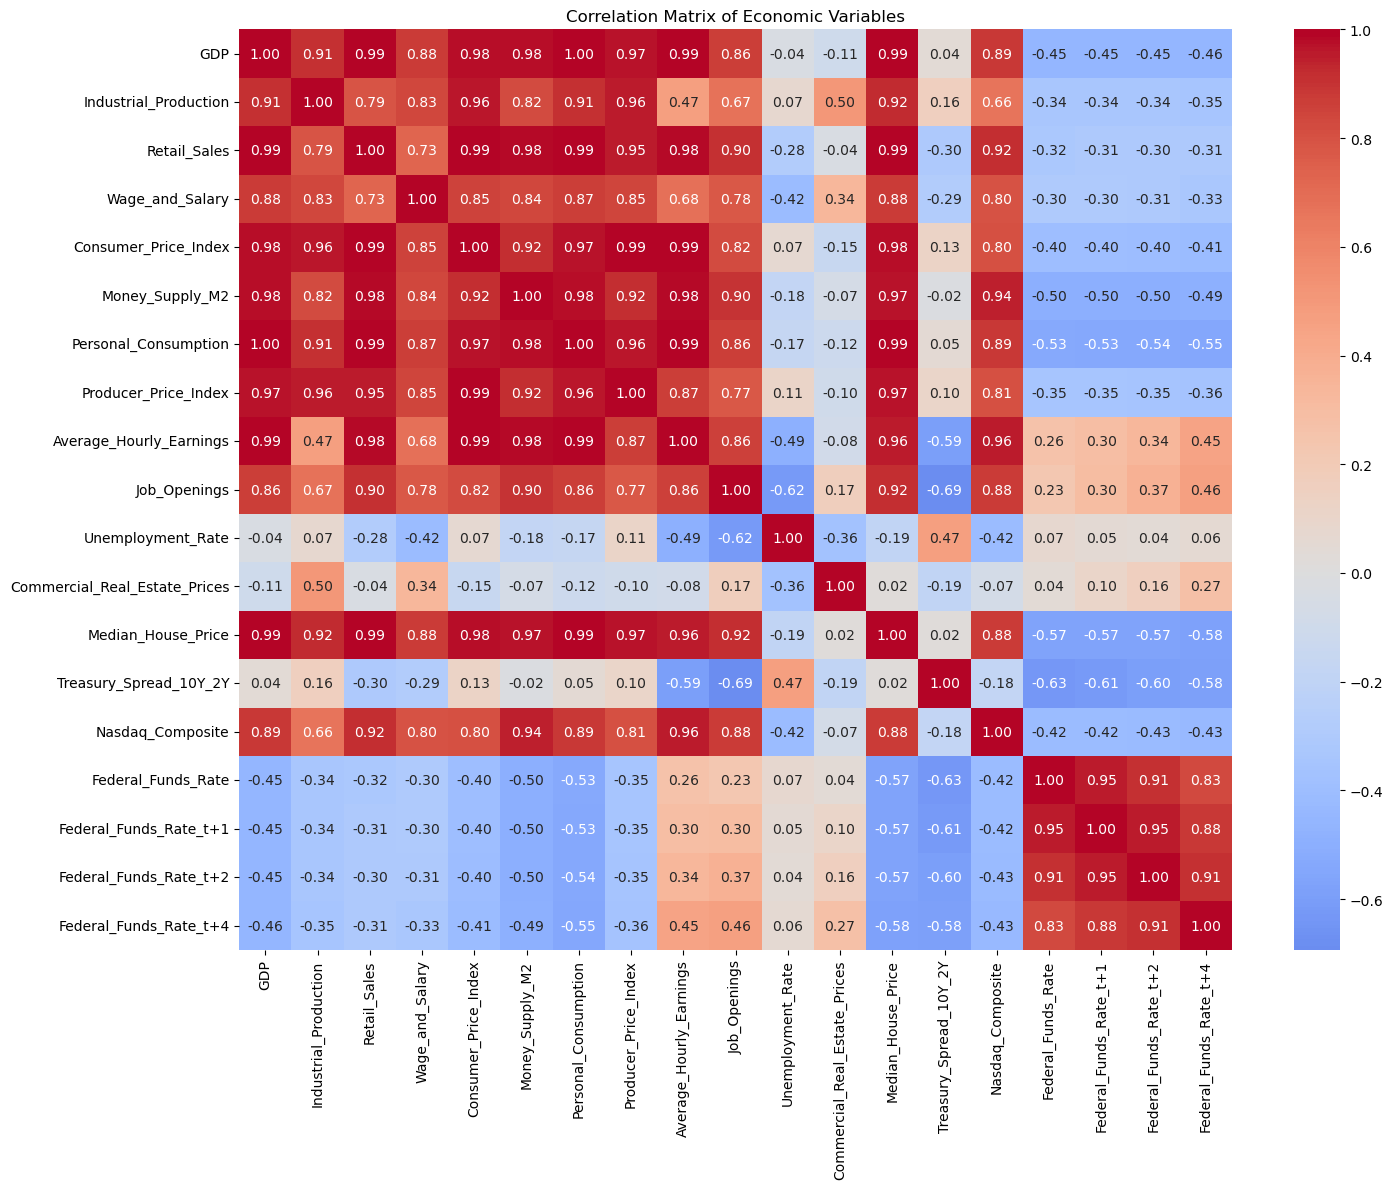

In [95]:
# Create correlation matrix plot
plt.figure(figsize=(15, 12))
sns.heatmap(df_quarterly.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Economic Variables')
plt.tight_layout()
plt.show()

# Feature Plotting Function

In [96]:
def plot_feature_importance(models, feature_cols, model_type="XGBoost"):
    # Create vertically stacked subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 20))
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    horizons = [1, 2, 4]
    
    for ax, horizon, color in zip(axes, horizons, colors):
        # Get feature importance from existing model
        importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': models[horizon].feature_importances_
        }).sort_values('importance', ascending=True)
        
        # Create horizontal bar plot
        bars = ax.barh(np.arange(len(importance)), importance['importance'], color=color, alpha=0.6)
        ax.set_yticks(np.arange(len(importance)))
        ax.set_yticklabels(importance['feature'], fontsize=10)
        
        # Add value labels on the bars
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', 
                    ha='left', va='center', fontsize=9)
        
        ax.set_title(f'{model_type} - {horizon}Q Ahead Prediction', pad=20)
        ax.set_xlabel('Feature Importance')
        ax.grid(True, axis='x', alpha=0.3)
        
        # Adjust layout to prevent label cutoff
        ax.set_xlim(0, max(importance['importance']) * 1.15)
    
    plt.tight_layout()
    plt.show()

# Boosting

In [97]:
def build_and_evaluate_boost_model(X, y, horizon, feature_names):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Create and train model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nResults for {horizon}-quarter ahead prediction:")
    print(f"R² Score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    
    return model, X_test, y_test, y_pred

In [98]:
# Create and evaluate models for each horizon
models = {}
predictions = {}
for horizon in [1, 2, 4]:
    target = f'Federal_Funds_Rate_t+{horizon}'
    y = df_quarterly[target].dropna()
    
    # Align X with y
    X_aligned = X.loc[y.index]
    
    print(f"\n{'='*50}")
    print(f"Training model for {horizon}-quarter ahead prediction")
    model, X_test, y_test, y_pred = build_and_evaluate_boost_model(
        X_aligned, y, horizon, feature_cols
    )
    
    models[horizon] = model
    predictions[horizon] = {
        'test_dates': X_test.index,
        'actual': y_test,
        'predicted': y_pred
    }


Training model for 1-quarter ahead prediction

Results for 1-quarter ahead prediction:
R² Score: 0.875
MSE: 0.392
MAE: 0.526

Training model for 2-quarter ahead prediction

Results for 2-quarter ahead prediction:
R² Score: 0.568
MSE: 1.352
MAE: 0.964

Training model for 4-quarter ahead prediction

Results for 4-quarter ahead prediction:
R² Score: 0.287
MSE: 2.234
MAE: 0.981


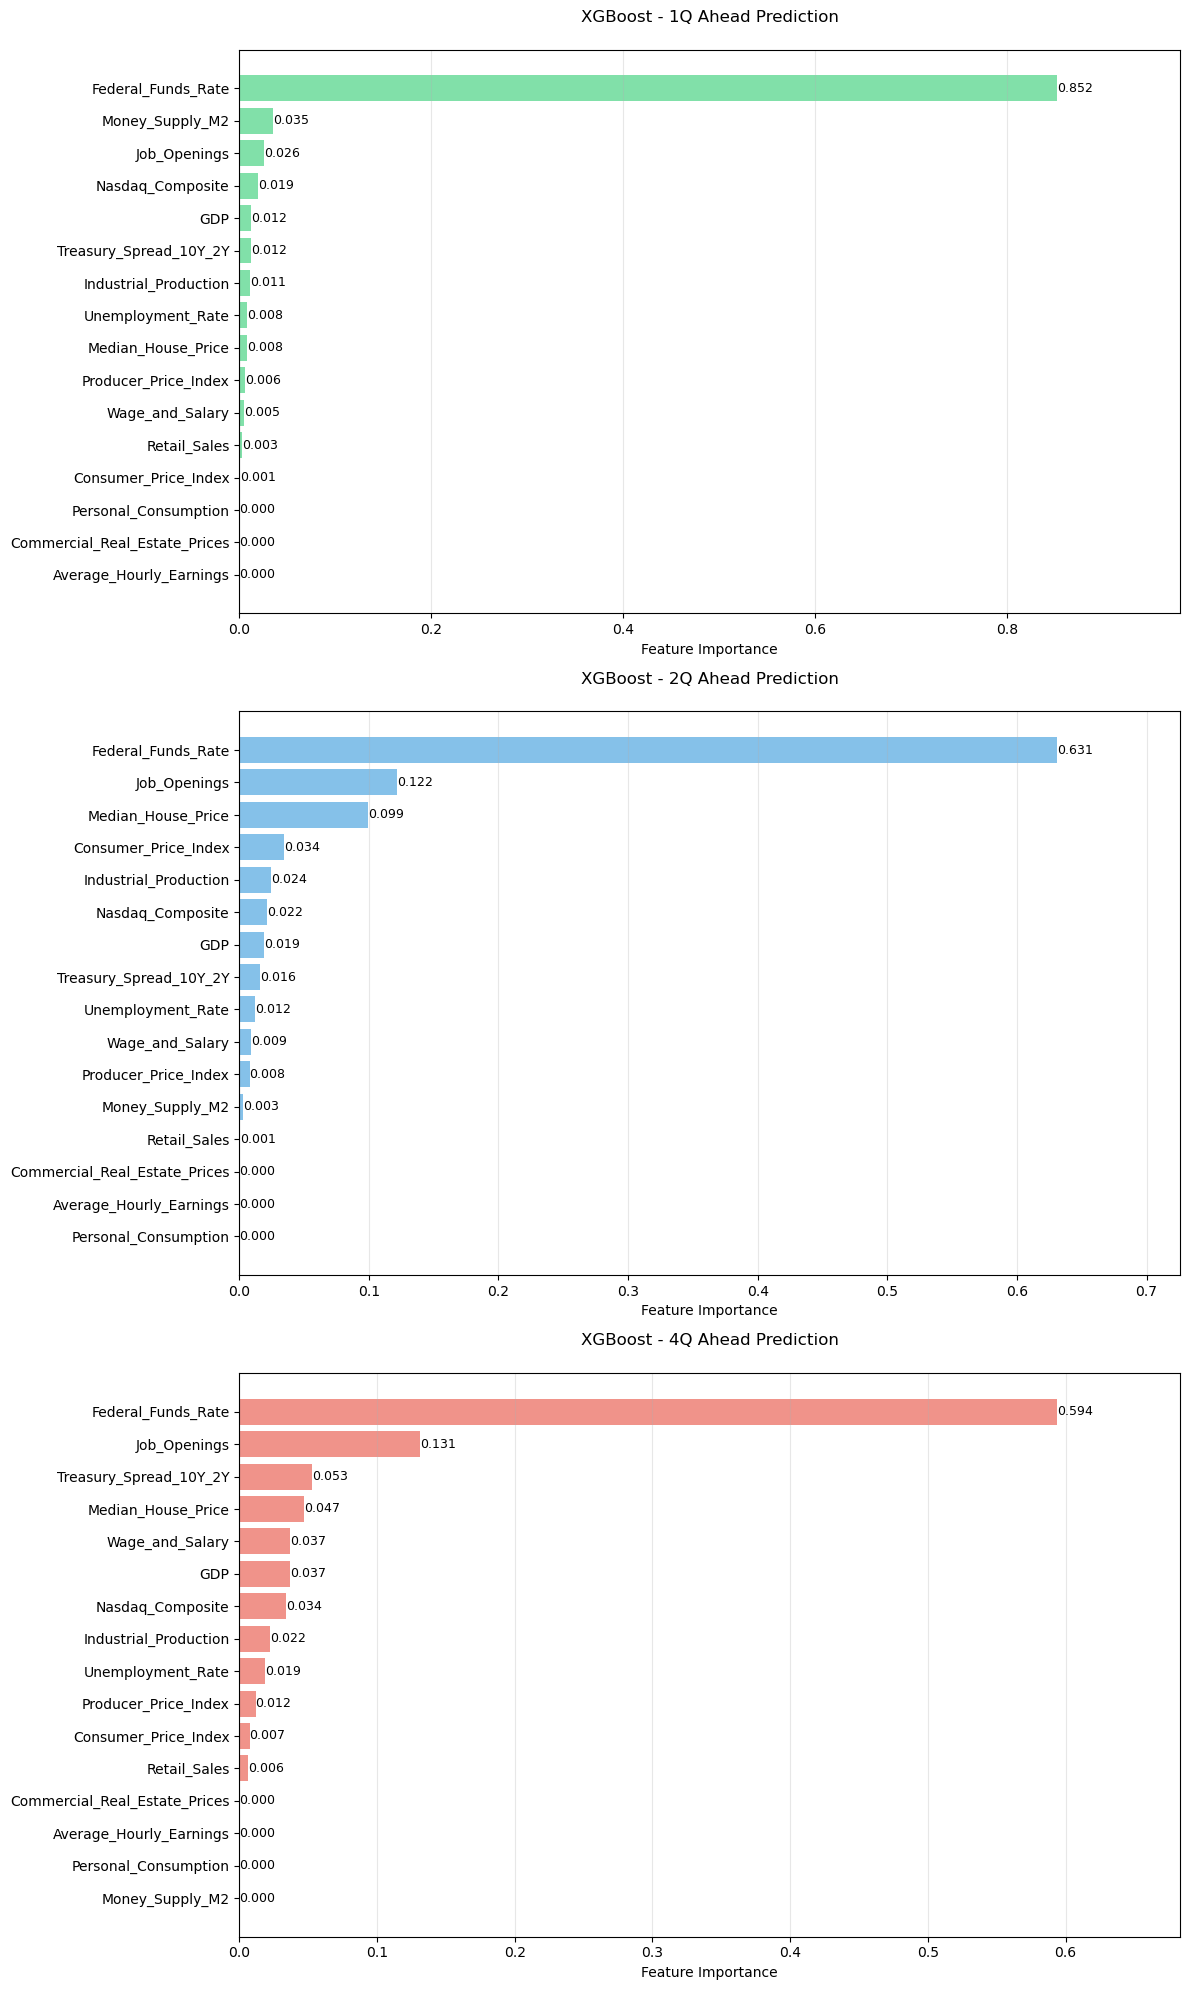

In [99]:
# Use the function with existing models
plot_feature_importance(models, feature_cols, model_type="XGBoost")

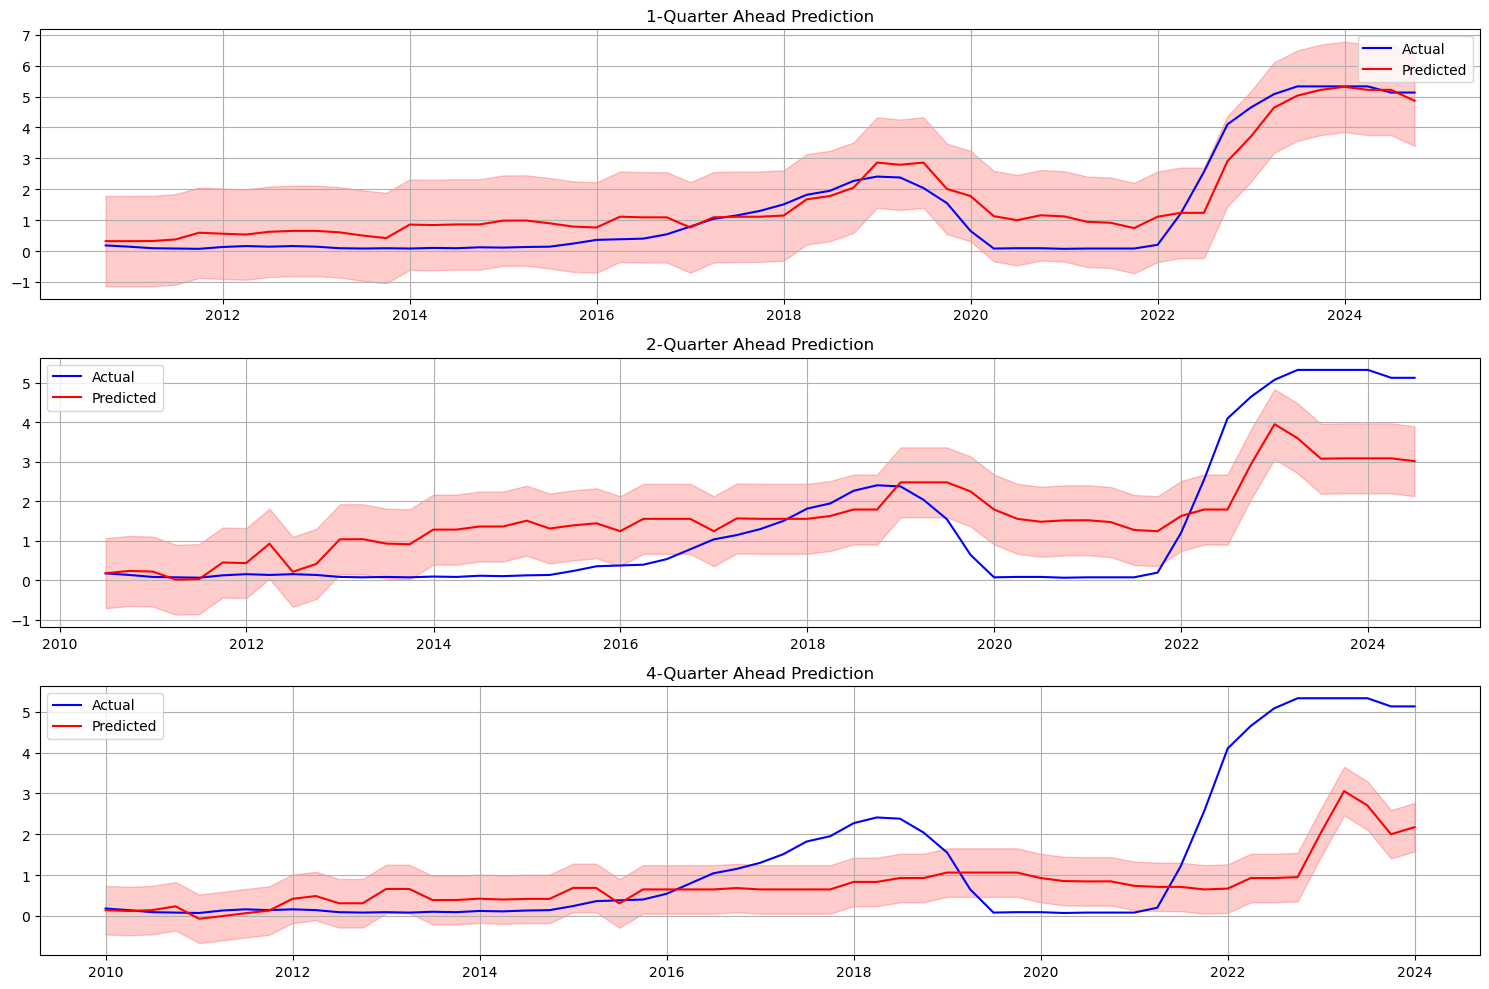

In [100]:
# Plot predictions vs actual for each horizon
plt.figure(figsize=(15, 10))
for i, horizon in enumerate([1, 2, 4], 1):
    plt.subplot(3, 1, i)
    plt.plot(predictions[horizon]['test_dates'], 
             predictions[horizon]['actual'], 
             label='Actual', color='blue')
    plt.plot(predictions[horizon]['test_dates'], 
             predictions[horizon]['predicted'], 
             label='Predicted', color='red')
    plt.fill_between(predictions[horizon]['test_dates'],
                    predictions[horizon]['predicted'] - predictions[horizon]['predicted'].std(),
                    predictions[horizon]['predicted'] + predictions[horizon]['predicted'].std(),
                    color='red', alpha=0.2)
    plt.title(f'{horizon}-Quarter Ahead Prediction')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
# Make future predictions
latest_data = X.iloc[-1:]
future_predictions = {}
print("\nFuture Predictions:")
for horizon in [1, 2, 4]:
    pred = models[horizon].predict(latest_data)[0]
    std = predictions[horizon]['predicted'].std()
    future_predictions[horizon] = {
        'prediction': pred,
        'lower_bound': pred - std,
        'upper_bound': pred + std
    }
    print(f"\n{horizon}-quarter ahead prediction:")
    print(f"Point estimate: {pred:.2f}")
    print(f"Confidence interval: [{pred-std:.2f}, {pred+std:.2f}]")


Future Predictions:

1-quarter ahead prediction:
Point estimate: 4.84
Confidence interval: [3.38, 6.31]

2-quarter ahead prediction:
Point estimate: 2.97
Confidence interval: [2.09, 3.86]

4-quarter ahead prediction:
Point estimate: 2.46
Confidence interval: [1.87, 3.05]


# Random Forest

In [102]:
def build_and_evaluate_rf_model(X, y, horizon, feature_names):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Create and train model
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=4,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\nResults for {horizon}-quarter ahead prediction:")
    print(f"R² Score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    
    # Print feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    
    
    return model, X_test, y_test, y_pred, importance

# Create and evaluate models for each horizon
models = {}
predictions = {}
importances = {}
for horizon in [1, 2, 4]:
    target = f'Federal_Funds_Rate_t+{horizon}'
    y = df_quarterly[target].dropna()
    
    # Align X with y
    X_aligned = X.loc[y.index]
    
    print(f"\n{'='*50}")
    print(f"Training model for {horizon}-quarter ahead prediction")
    model, X_test, y_test, y_pred, importance = build_and_evaluate_rf_model(
        X_aligned, y, horizon, feature_cols
    )
    
    models[horizon] = model
    predictions[horizon] = {
        'test_dates': X_test.index,
        'actual': y_test,
        'predicted': y_pred
    }
    importances[horizon] = importance


Training model for 1-quarter ahead prediction

Results for 1-quarter ahead prediction:
R² Score: 0.901
MSE: 0.310
MAE: 0.433

Training model for 2-quarter ahead prediction

Results for 2-quarter ahead prediction:
R² Score: 0.714
MSE: 0.897
MAE: 0.818

Training model for 4-quarter ahead prediction

Results for 4-quarter ahead prediction:
R² Score: 0.415
MSE: 1.834
MAE: 1.137


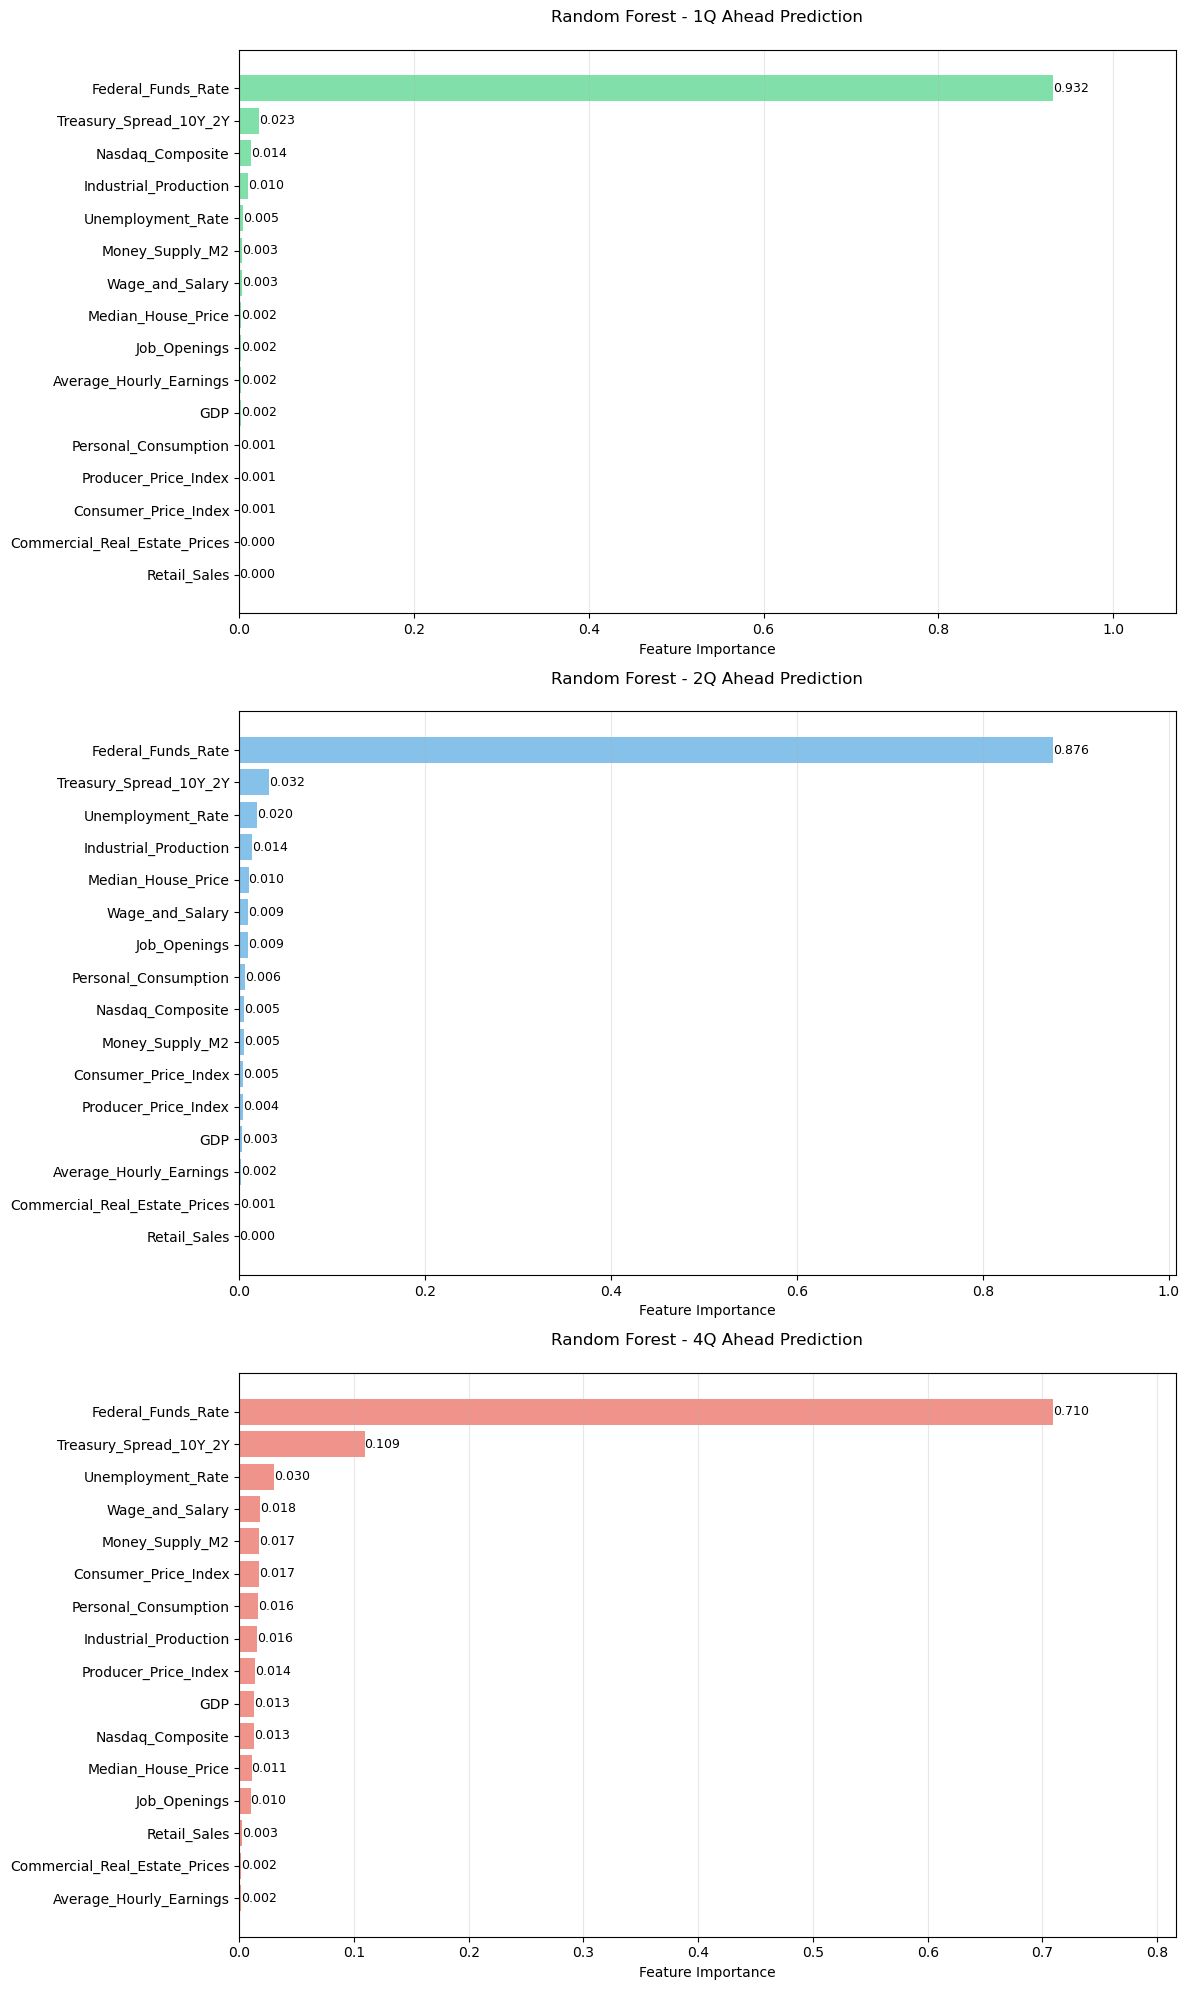

In [103]:
# Use the function with existing models
plot_feature_importance(models, feature_cols, model_type="Random Forest")

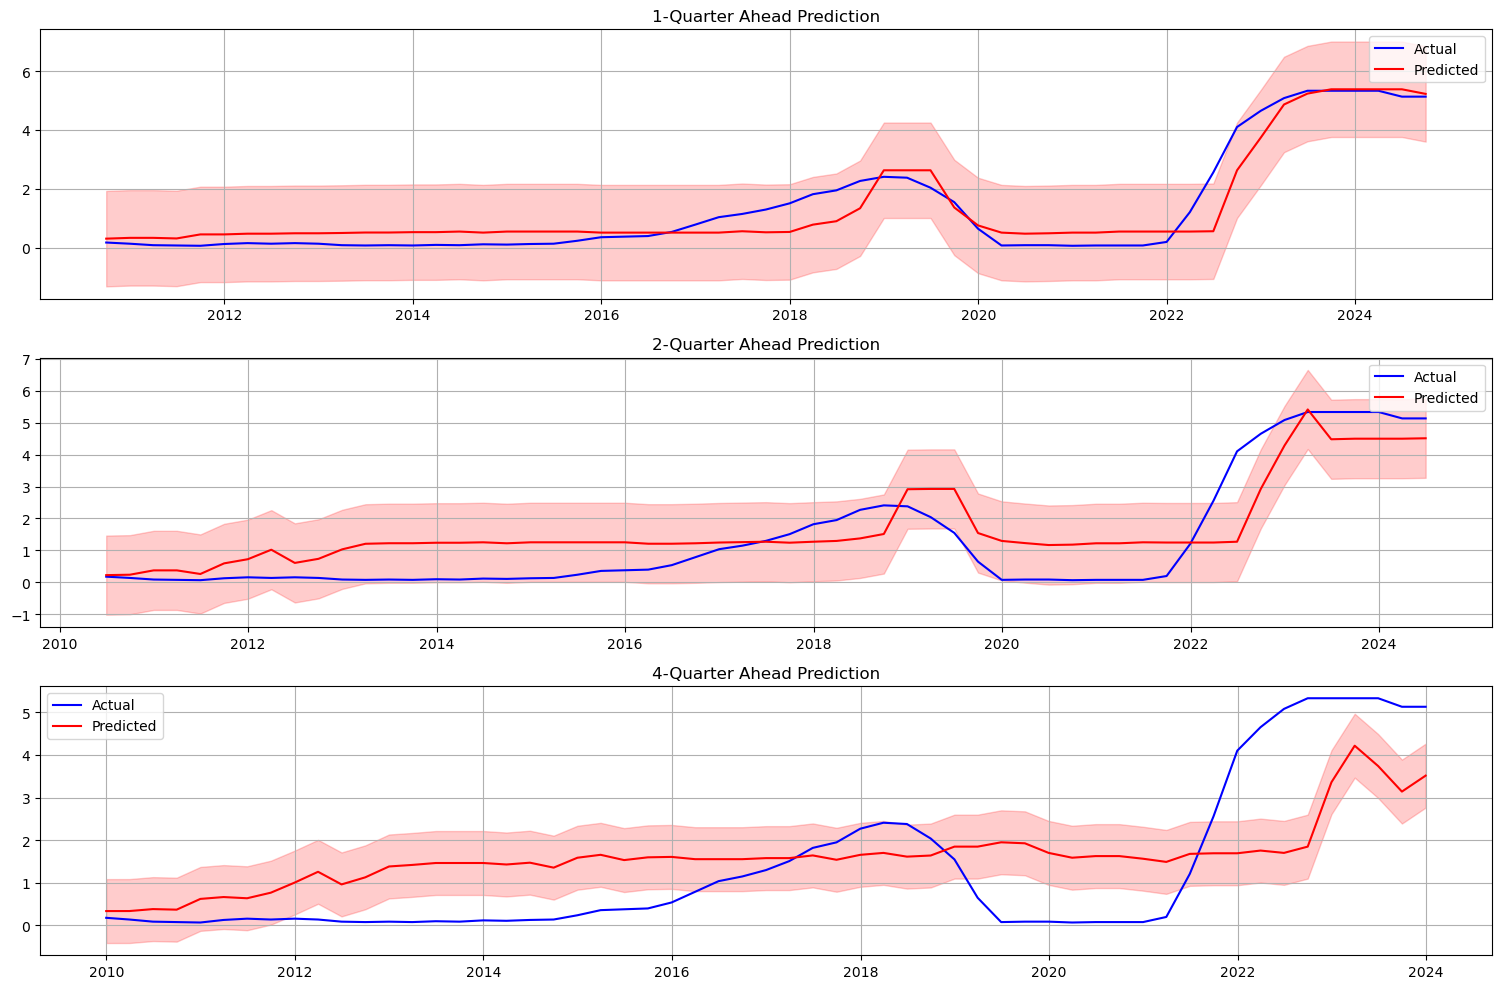

In [104]:
# Plot predictions vs actual for each horizon
plt.figure(figsize=(15, 10))
for i, horizon in enumerate([1, 2, 4], 1):
    plt.subplot(3, 1, i)
    plt.plot(predictions[horizon]['test_dates'], 
             predictions[horizon]['actual'], 
             label='Actual', color='blue')
    plt.plot(predictions[horizon]['test_dates'], 
             predictions[horizon]['predicted'], 
             label='Predicted', color='red')
    plt.fill_between(predictions[horizon]['test_dates'],
                    predictions[horizon]['predicted'] - predictions[horizon]['predicted'].std(),
                    predictions[horizon]['predicted'] + predictions[horizon]['predicted'].std(),
                    color='red', alpha=0.2)
    plt.title(f'{horizon}-Quarter Ahead Prediction')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [105]:
# Make future predictions
latest_data = X.iloc[-1:]
print("\nFuture Predictions:")
for horizon in [1, 2, 4]:
    pred = models[horizon].predict(latest_data)[0]
    std = predictions[horizon]['predicted'].std()
    print(f"\n{horizon}-quarter ahead prediction:")
    print(f"Point estimate: {pred:.2f}")
    print(f"Confidence interval: [{pred-std:.2f}, {pred+std:.2f}]")


Future Predictions:

1-quarter ahead prediction:
Point estimate: 5.22
Confidence interval: [3.60, 6.84]

2-quarter ahead prediction:
Point estimate: 4.44
Confidence interval: [3.21, 5.68]

4-quarter ahead prediction:
Point estimate: 2.62
Confidence interval: [1.88, 3.37]
